In [1]:
import os
import json
import numpy as np
import open3d as o3d
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# ------- Path config: adjust to your setup -------

# 1. GT point cloud (Stage A depth PLY)
GT_PLY = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/gt_pointcloud_partial.ply"

# 2. COLMAP dense root dir (the one you provided)
DENSE_ROOT = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_dense"

# Specific files
DENSE_PLY = os.path.join(DENSE_ROOT, "fused.ply")
POISSON_PLY = os.path.join(DENSE_ROOT, "meshed-poisson.ply")
SPARSE_BIN_DIR = os.path.join(DENSE_ROOT, "sparse")  # If you want to read with pycolmap later

# 3. Stage B.2 alignment result (Sim3: COLMAP world → GT world)
ALIGN_JSON = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/colmap_to_gt_alignment.json"

# 4. Output directory
OUT_DIR = "/data1_ycao/chua/projects/cdTeacher/outputs/stage_C/c1_descending_t2_v2/dense_eval"
os.makedirs(OUT_DIR, exist_ok=True)

print("GT_PLY      :", GT_PLY)
print("DENSE_PLY   :", DENSE_PLY)
print("POISSON_PLY :", POISSON_PLY)
print("SPARSE_BIN  :", SPARSE_BIN_DIR)
print("ALIGN_JSON  :", ALIGN_JSON)
print("OUT_DIR     :", OUT_DIR)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
GT_PLY      : /data1_ycao/chua/projects/cdTeacher/outputs/stage_A/c1_descending_t2_v2/gt_pointcloud_partial.ply
DENSE_PLY   : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_dense/fused.ply
POISSON_PLY : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_dense/meshed-poisson.ply
SPARSE_BIN  : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/colmap_dense/sparse
ALIGN_JSON  : /data1_ycao/chua/projects/cdTeacher/outputs/stage_B/c1_descending_t2_v2/alignment/colmap_to_gt_alignment.json
OUT_DIR     : /data1_ycao/chua/projects/cdTeacher/outputs/stage_C/c1_descending_t2_v2/dense_eval


In [2]:
# Load GT point cloud
pcd_gt = o3d.io.read_point_cloud(GT_PLY)
gt_pts = np.asarray(pcd_gt.points)
print("GT points:", gt_pts.shape)

# Load COLMAP dense point cloud (fused.ply)
pcd_dense = o3d.io.read_point_cloud(DENSE_PLY)
dense_pts = np.asarray(pcd_dense.points)
print("Dense points:", dense_pts.shape)

# If you also want a rough look at the Poisson mesh:
if os.path.exists(POISSON_PLY):
    pcd_poisson = o3d.io.read_point_cloud(POISSON_PLY)
    poisson_pts = np.asarray(pcd_poisson.points)
    print("Poisson points:", poisson_pts.shape)
else:
    pcd_poisson = None
    print("Poisson mesh not found at", POISSON_PLY)


GT points: (615000, 3)
Dense points: (443036, 3)
Poisson points: (820190, 3)


In [3]:
with open(ALIGN_JSON, "r") as f:
    align = json.load(f)

s = align["scale"]
R = np.array(align["R_align"], dtype=np.float64)
t = np.array(align["t_align"], dtype=np.float64)

print("Scale s:", s)
print("R_align:\n", R)
print("t_align:", t)
print("det(R_align):", np.linalg.det(R))


Scale s: 0.004330465761430109
R_align:
 [[ 0.53029943 -0.17695044  0.82913874]
 [ 0.37374189 -0.82902986 -0.41596453]
 [ 0.76098588  0.53046963 -0.37350027]]
t_align: [-0.46723646 -0.1790355  -0.32835542]
det(R_align): 0.9999999999999984


In [ ]:
# Formula: X_gt ≈ s * R @ X_colmap + t

dense_aligned = (s * (R @ dense_pts.T).T) + t
print("dense_aligned shape:", dense_aligned.shape)

# Convert back to open3d for later visualization
pcd_dense_aligned = o3d.geometry.PointCloud()
pcd_dense_aligned.points = o3d.utility.Vector3dVector(dense_aligned)
pcd_dense_aligned.paint_uniform_color([1.0, 0.706, 0.0])  # yellow

pcd_gt_vis = o3d.geometry.PointCloud()
pcd_gt_vis.points = o3d.utility.Vector3dVector(gt_pts)
pcd_gt_vis.paint_uniform_color([0.0, 0.651, 0.929])       # blue

print(pcd_gt_vis)
print(pcd_dense_aligned)


dense_aligned shape: (443036, 3)
PointCloud with 615000 points.
PointCloud with 443036 points.


In [5]:
# Limit dense points to avoid OOM
MAX_DENSE_POINTS = 300_000

if dense_aligned.shape[0] > MAX_DENSE_POINTS:
    idx = np.random.choice(dense_aligned.shape[0], MAX_DENSE_POINTS, replace=False)
    dense_used = dense_aligned[idx]
else:
    dense_used = dense_aligned

print("Using dense points:", dense_used.shape)

# Build k-d tree
tree_gt = cKDTree(gt_pts)
tree_dense = cKDTree(dense_used)

# Dense → GT
d_c2g, _ = tree_gt.query(dense_used, k=1)

# GT → Dense
d_g2c, _ = tree_dense.query(gt_pts, k=1)

def print_stats(name, dists):
    print(f"{name} stats (meters):")
    print("  mean   :", float(dists.mean()))
    print("  median :", float(np.median(dists)))
    print("  95%ile :", float(np.percentile(dists, 95)))
    print("  max    :", float(dists.max()))
    print()

print_stats("Dense → GT", d_c2g)
print_stats("GT → Dense", d_g2c)

chamfer_like = d_c2g.mean() + d_g2c.mean()
print("Chamfer-like distance (mean d_c2g + mean d_g2c):", float(chamfer_like))

# Save error array for future plots
np.save(os.path.join(OUT_DIR, "dense_to_gt_nn.npy"), d_c2g)
np.save(os.path.join(OUT_DIR, "gt_to_dense_nn.npy"), d_g2c)


Using dense points: (300000, 3)
Dense → GT stats (meters):
  mean   : 0.003836507884271206
  median : 0.0007438559219982148
  95%ile : 0.0056644774329977065
  max    : 1.8313750140291112

GT → Dense stats (meters):
  mean   : 0.0013007250000798133
  median : 0.0006063805234808217
  95%ile : 0.005622350909599934
  max    : 0.014246186941177092

Chamfer-like distance (mean d_c2g + mean d_g2c): 0.00513723288435102


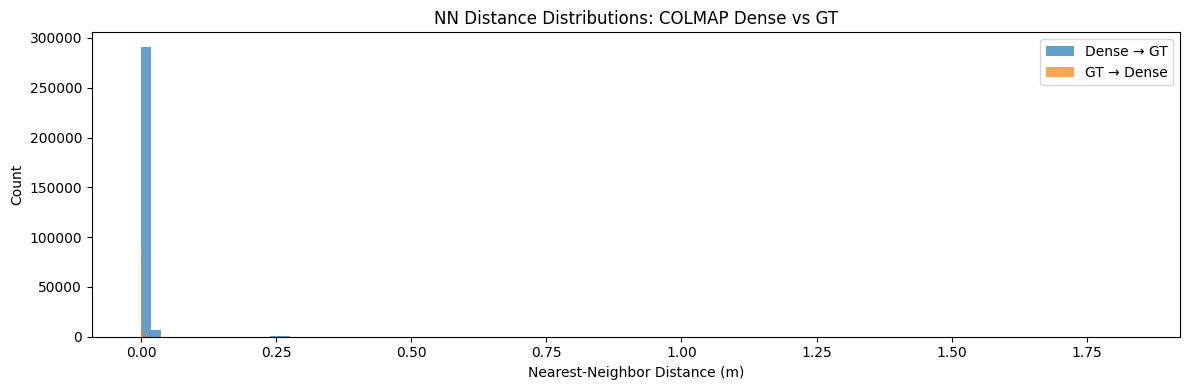

In [6]:
plt.figure(figsize=(12,4))
plt.hist(d_c2g, bins=100, alpha=0.7, label="Dense → GT")
plt.hist(d_g2c, bins=100, alpha=0.7, label="GT → Dense")
plt.xlabel("Nearest-Neighbor Distance (m)")
plt.ylabel("Count")
plt.legend()
plt.title("NN Distance Distributions: COLMAP Dense vs GT")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dense_gt_nn_hist.png"), dpi=200)
plt.show()


In [7]:
# Prepare a color per dense_used point (based on Dense→GT distance)
# Simple normalization: clamp error to [0, max_vis]
max_vis = np.percentile(d_c2g, 99)  # 99th percentile as upper bound to limit outlier influence
d_vis = np.clip(d_c2g, 0.0, max_vis) / max_vis  # 0~1

# Simple colormap: blue (small error) → red (large error)
# Manual mapping: color = [r, g, b]
colors = np.zeros((dense_used.shape[0], 3), dtype=np.float32)
colors[:, 0] = d_vis                # R channel = error
colors[:, 2] = 1.0 - d_vis          # B channel = 1 - error

pcd_dense_colored = o3d.geometry.PointCloud()
pcd_dense_colored.points = o3d.utility.Vector3dVector(dense_used)
pcd_dense_colored.colors = o3d.utility.Vector3dVector(colors)

# Save a colored dense ply for viewing in open3d GUI / Meshlab / WebGL
colored_ply_path = os.path.join(OUT_DIR, "dense_aligned_colored_by_error.ply")
o3d.io.write_point_cloud(colored_ply_path, pcd_dense_colored)
print("Colored dense point cloud saved to:", colored_ply_path)

# Similarly, you could also:
# o3d.visualization.draw_geometries([pcd_gt_vis, pcd_dense_colored])


Colored dense point cloud saved to: /data1_ycao/chua/projects/cdTeacher/outputs/stage_C/c1_descending_t2_v2/dense_eval/dense_aligned_colored_by_error.ply
